In [16]:
import pandas as pd
import fpsnippets


In [31]:
toxic_air_df = pd.read_csv('toxic_air_releases.csv')
toxic_air_df.head()


,_id,TRI_FACILITY_ID,DOC_CTRL_NUM,FACILITY_NAME,STREET_ADDRESS,CITY_NAME,COUNTY_NAME,STATE_COUNTY_FIPS_CODE,STATE_ABBR,ZIP_CODE,...,NAICS_CODES,INDUSTRY_CODE,SRS_ID,PFAS_IND,ENVIRONMENTAL_MEDIUM,RELEASE_RANGE_CODE,REL_EST_AMT,RELEASE_NA,RELEASE_BASIS_EST_CODE,TOTAL_RELEASE
0,487972,15204PRTTSTABOR,1300140000694,PRUETT-SCHAFFER CHEMICAL CO INC.,3327 STAFFORD ST,PITTSBURGH,ALLEGHENY,42003,PA,15204,...,325510.0,325,84970.0,0,AIR STACK,NaN,NaN,0,E,390.0
1,487973,15104PCMTL11TAL,1300140029834,EPIC METALS CORP,11 TALBOT AVE,RANKIN,ALLEGHENY,42003,PA,15104,...,332312.0,332,84970.0,0,AIR STACK,NaN,NaN,0,C,3964.0
2,487974,15104PCMTL11TAL,1300140029846,EPIC METALS CORP,11 TALBOT AVE,RANKIN,ALLEGHENY,42003,PA,15104,...,332312.0,332,7443.0,0,AIR STACK,NaN,NaN,0,C,1497.0
3,487975,15233ZMMRM2020K,1300140055195,E.E. ZIMMERMAN CO,2020 KNOTT ST,PITTSBURGH,ALLEGHENY,42003,PA,15233,...,424690.0,4246,7443.0,0,AIR STACK,NaN,NaN,0,C,133.0
4,487976,15233ZMMRM2020K,1300140055207,E.E. ZIMMERMAN CO,2020 KNOTT ST,PITTSBURGH,ALLEGHENY,42003,PA,15233,...,424690.0,4246,4283.0,0,AIR STACK,NaN,NaN,0,C,640.0


In [18]:
# Filter for recent data (last 10 years - 2015 onwards)
current_year = 2024
recent_years = 10
min_year = current_year - recent_years

recent_data = toxic_air_df[toxic_air_df['REPORTING_YEAR'] >= min_year].copy()


In [ ]:
zip_neighborhood_map = {}
unique_zips = recent_data['ZIP_CODE'].dropna().unique()

for zip_code in unique_zips:
    try:
        zip_int = int(float(str(zip_code).split('.')[0]))
        neighborhoods = fpsnippets.zip_to_neighborhoods(zip_int)
        if neighborhoods:
            zip_neighborhood_map[zip_code] = neighborhoods
    except (ValueError, TypeError):
        continue


In [32]:
neighborhood_releases = []

for idx, row in recent_data.iterrows():
    zip_code = row['ZIP_CODE']
    
    # Get neighborhoods for this zip code
    if pd.notna(zip_code) and zip_code in zip_neighborhood_map:
        neighborhoods = zip_neighborhood_map[zip_code]
        total_release = row['TOTAL_RELEASE']
        
        if pd.notna(total_release):
            try:
                release_value = float(total_release)
                release_per_neighborhood = release_value / len(neighborhoods) if neighborhoods else 0
                
                for neighborhood in neighborhoods:
                    neighborhood_releases.append({
                        'neighborhood': neighborhood,
                        'total_release': release_per_neighborhood,  # Pounds per neighborhood
                        'zip_code': zip_code,
                        'year': row['REPORTING_YEAR']
                    })
            except (ValueError, TypeError):
                continue

neighborhood_df = pd.DataFrame(neighborhood_releases)


In [24]:
neighborhood_rankings = neighborhood_df.groupby('neighborhood')['total_release'].sum().reset_index()
neighborhood_rankings.columns = ['neighborhood', 'total_toxic_release']

# Sort from least to most toxic
neighborhood_rankings = neighborhood_rankings.sort_values(by='total_toxic_release', ascending=True)
neighborhood_rankings


,neighborhood,total_toxic_release
57,Westwood,0.067750
18,Crafton Heights,0.067750
40,Oakwood,0.067750
20,East Carnegie,0.067750
26,Greenfield,0.075000
28,Hazelwood,0.075000
25,Glen Hazel,0.075000
3,Arlington,0.395243
2,Allentown,0.395243
4,Arlington Heights,0.395243


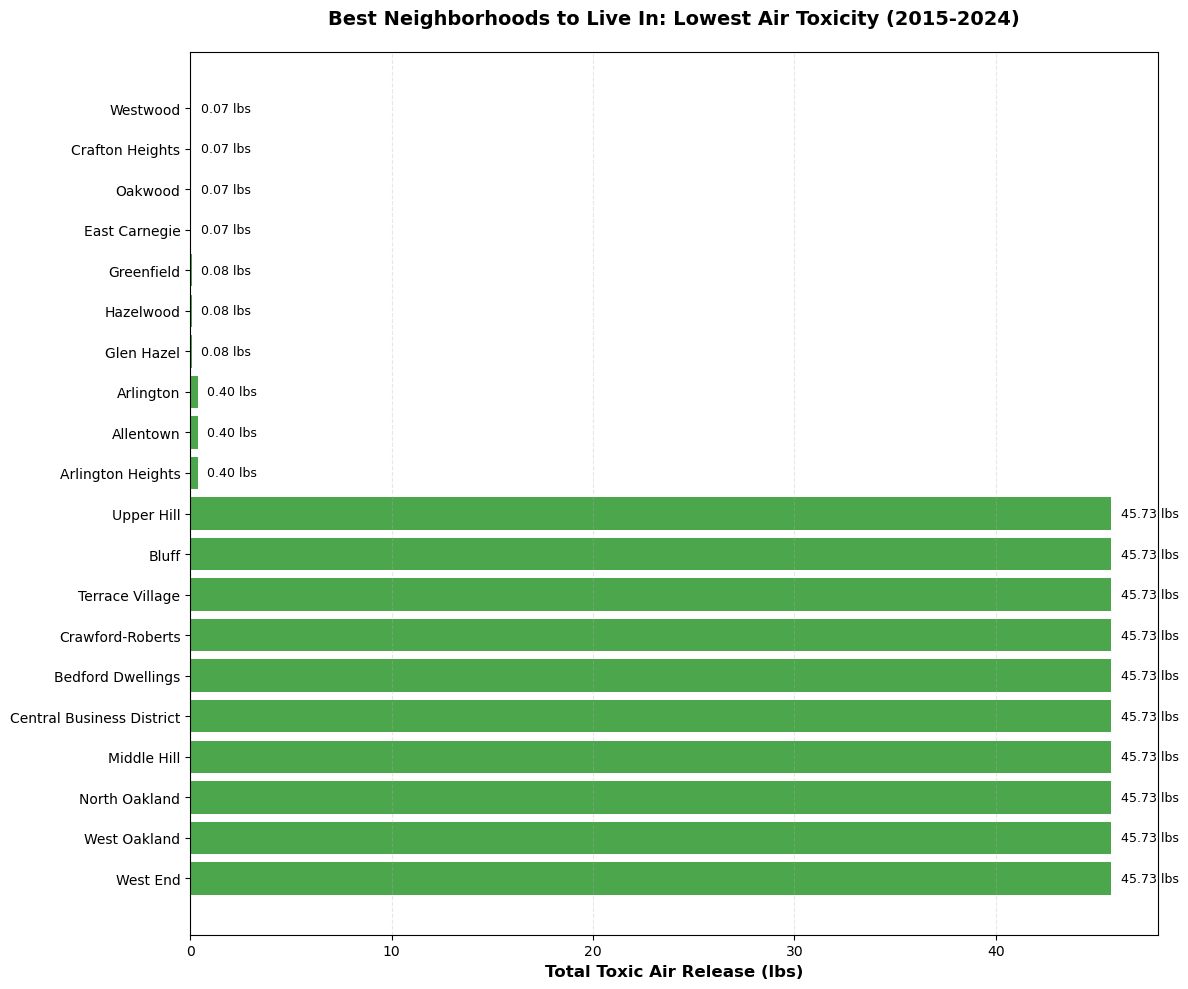

In [30]:
import matplotlib.pyplot as plt

top_20_best = neighborhood_rankings.head(20)

plt.figure(figsize=(12, 10))
bars = plt.barh(range(len(top_20_best)), top_20_best['total_toxic_release'], color='green', alpha=0.7)
plt.yticks(range(len(top_20_best)), top_20_best['neighborhood'])
plt.xlabel('Total Toxic Air Release (lbs)', fontsize=12, fontweight='bold')
plt.title('Best Neighborhoods to Live In: Lowest Air Toxicity (2015-2024)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

for i, (idx, row) in enumerate(top_20_best.iterrows()):
    plt.text(row['total_toxic_release'] + max(top_20_best['total_toxic_release']) * 0.01, 
             i, f"{row['total_toxic_release']:.2f} lbs", 
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



Conclusion: Any of the top 5 listed would be safe in terms of air quality